In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import json
import copy
import math
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

In [3]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
def set_device():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  if torch.cuda.is_available:
    print('PyTorch can use GPUs!')
  else:
    print('PyTorch cannot use GPUs.')

  return device

device = set_device()

PyTorch can use GPUs!


In [5]:
DEBUG = True
# DEBUG = False

In [6]:
def build_windows(data, window_width=1000, stride=None, normalize=False):
    if stride is None:
        stride = 1

    # Create view of sliding windows using NumPy's striding tricks
    shape = ((data.shape[0] - window_width) // stride + 1, window_width, data.shape[1])
    strides = (data.strides[0] * stride, data.strides[0], data.strides[1])

    windows = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

    # Normalize channels independently if requested
    if normalize:
        # Reshape to flatten all windows for channel-wise normalization
        reshaped_data = windows.reshape(-1, data.shape[1])

        # Normalize each channel independently using z-score (mean=0, std=1)
        normalized_data = (reshaped_data - reshaped_data.mean(axis=0)) / reshaped_data.std(axis=0)

        # Reshape back to original windows shape
        windows = normalized_data.reshape(shape)

    return torch.from_numpy(windows).float()

In [7]:
class MyoCombinedDataset(Dataset):
  def __init__(self, root_dir, num_files, split, split_ratio=0.8, num_samples_per_window=1000, stride=1, transform=None):
    myo_datas = []
    leap_datas = []

    for i in range(num_files):
      myo_file = f"s{i+1}_bleData.csv"
      # myo_file = f"myo8_rect_s{i+1}_bleData.csv"
      # myo_file = f"myo4_env_s{i+1}_bleData.csv"
      myo_file_path = os.path.join(root_dir, myo_file)
      myo_df = pd.read_csv(myo_file_path)
      myo_data = np.asarray(myo_df.iloc[:, 2:])
      myo_datas.append(myo_data)

      # leap_file = f"myo4_env_s{i+1}_leapData.csv"
      # leap_file = f"myo8_rect_s{i+1}_leapData.csv"
      leap_file = f"s{i+1}_leapData.csv"
      leap_file_path = os.path.join(root_dir, leap_file)
      leap_df = pd.read_csv(leap_file_path)
      leap_data = np.asarray(leap_df.iloc[:, 2:])
      leap_datas.append(leap_data)


    myo_data = [build_windows(arr, window_width=num_samples_per_window, stride=stride, normalize=True) for arr in myo_datas]
    self.myo_data = torch.cat(myo_data, dim=0)

    leap_data = [build_windows(arr, window_width=num_samples_per_window, stride=stride) for arr in leap_datas]
    self.leap_data = torch.cat(leap_data, dim=0)

    # TODO: Potentially shuffle data before train-test split? Get rid of
    #   closing finger tracking script artifacts?
    # Combine and shuffle data to remove potential sequential artifacts
    shuffle_indices = torch.randperm(self.myo_data.shape[0])
    self.myo_data = self.myo_data[shuffle_indices]
    self.leap_data = self.leap_data[shuffle_indices]

    assert(self.myo_data.shape[0] == self.leap_data.shape[0])

    self.split = split
    self.num_samples_per_window = num_samples_per_window
    self.transform = transform

    if split == 'train':
      self.myo_data = self.myo_data[:int(split_ratio*len(self.myo_data))]
      self.leap_data = self.leap_data[:int(split_ratio*len(self.leap_data))]
    elif split == 'test':
      self.myo_data = self.myo_data[int(split_ratio*len(self.myo_data)):]
      self.leap_data = self.leap_data[int(split_ratio*len(self.leap_data)):]

    print("Dataset created")
    print(self.myo_data.shape)
    print(self.leap_data.shape)

  def __len__(self):
    return self.myo_data.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    myo_sample = self.myo_data[idx, :].type(torch.float32).unsqueeze(0)
    leap_sample = self.leap_data[idx,:].type(torch.float32).unsqueeze(0)

    if myo_sample.shape[2] == 4:
      padding = torch.zeros((myo_sample.shape[0], myo_sample.shape[1], 4))
      myo_sample = torch.cat((myo_sample, padding), dim=2)

    sample = {'myo': myo_sample, 'leap': leap_sample}

    if self.transform:
      sample = self.transform(sample)

    return sample

  def get_min_max(self, column_index):
    # print(f"min: {self.leap_data[:, :, column_index].min()}, max: {self.leap_data[:, :, column_index].max()}")
    return [self.leap_data[:, :, column_index].min(), self.leap_data[:, :, column_index].max()]

  def get_min_max_leap(self, columns):
    min_max = {}
    for column in columns:
      min_max[column] = self.get_min_max(column)
    return min_max


In [8]:
def plot_sample(sample, sample_num):
  fig = plt.figure()
  fig.set_figwidth(24)
  fig.set_figheight(6)
  ax = plt.subplot(1, 2, 1)
  plt.tight_layout()
  ax.set_title(f"Myo Sample {sample_num}")
  ax.plot(sample['myo'].numpy()[0], label=[f"Myo {i}" for i in range(len(sample['myo'].numpy()[0][0]))])
  ax.legend()

  feature_names = ["tm_aa", "tm_flex", "mcp_aa", "mcp_flex"]
  for i in range(4):
    feature_names += ["mcp_aa", "mcp_flex", "pip"]
  ax2 = plt.subplot(1, 2, 2)
  plt.tight_layout()
  ax2.set_title(f"Leap Sample {sample_num}")
  ax2.plot(sample['leap'].numpy()[0], label=feature_names)
  ax2.legend()


Dataset created
torch.Size([14238, 1000, 8])
torch.Size([14238, 1000, 16])
{'myo': tensor([[[ 0.3706, -0.1888, -0.8219,  ..., -0.2921,  0.3677, -0.1141],
         [ 0.4633, -0.1441, -0.8109,  ..., -0.2921,  0.2760, -0.1141],
         [ 0.5561, -0.0994, -0.7998,  ..., -0.2921,  0.1843, -0.1141],
         ...,
         [-0.1104, -0.7957, -0.4813,  ..., -0.8201, -1.5984,  0.0280],
         [-0.1193, -0.7669, -0.4279,  ..., -0.7914, -1.5275,  0.1800],
         [-0.1282, -0.8389, -0.3639,  ..., -0.7986, -1.3445,  0.1800]]]), 'leap': tensor([[[-17.9590,  17.9590,  -4.8190,  ...,  23.2710,  94.5680,  96.4460],
         [-17.8980,  17.8980,  -4.9730,  ...,  23.2010,  94.3600,  96.5540],
         [-18.0150,  18.0150,  -4.9310,  ...,  23.3780,  94.5860,  96.4370],
         ...,
         [-19.8500,  19.8500,  -1.0070,  ...,   8.3420,  29.7230,  25.4120],
         [-20.3310,  20.3310,  -0.9690,  ...,   8.3540,  30.3600,  26.6200],
         [-21.0070,  21.0070,  -0.9600,  ...,   9.2560,  32.2840,  

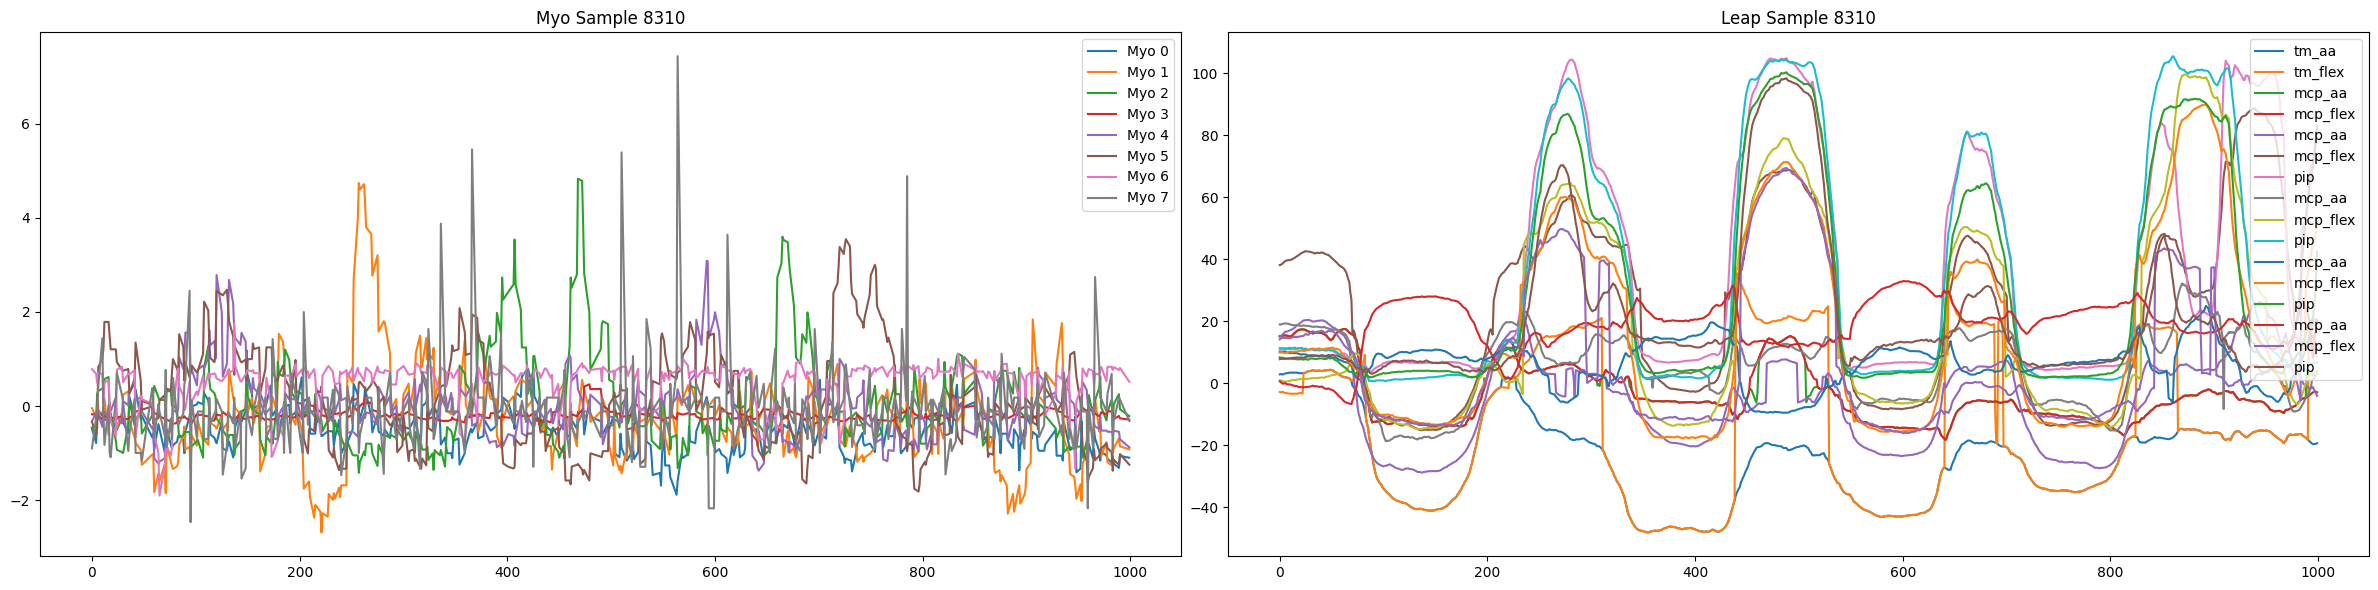

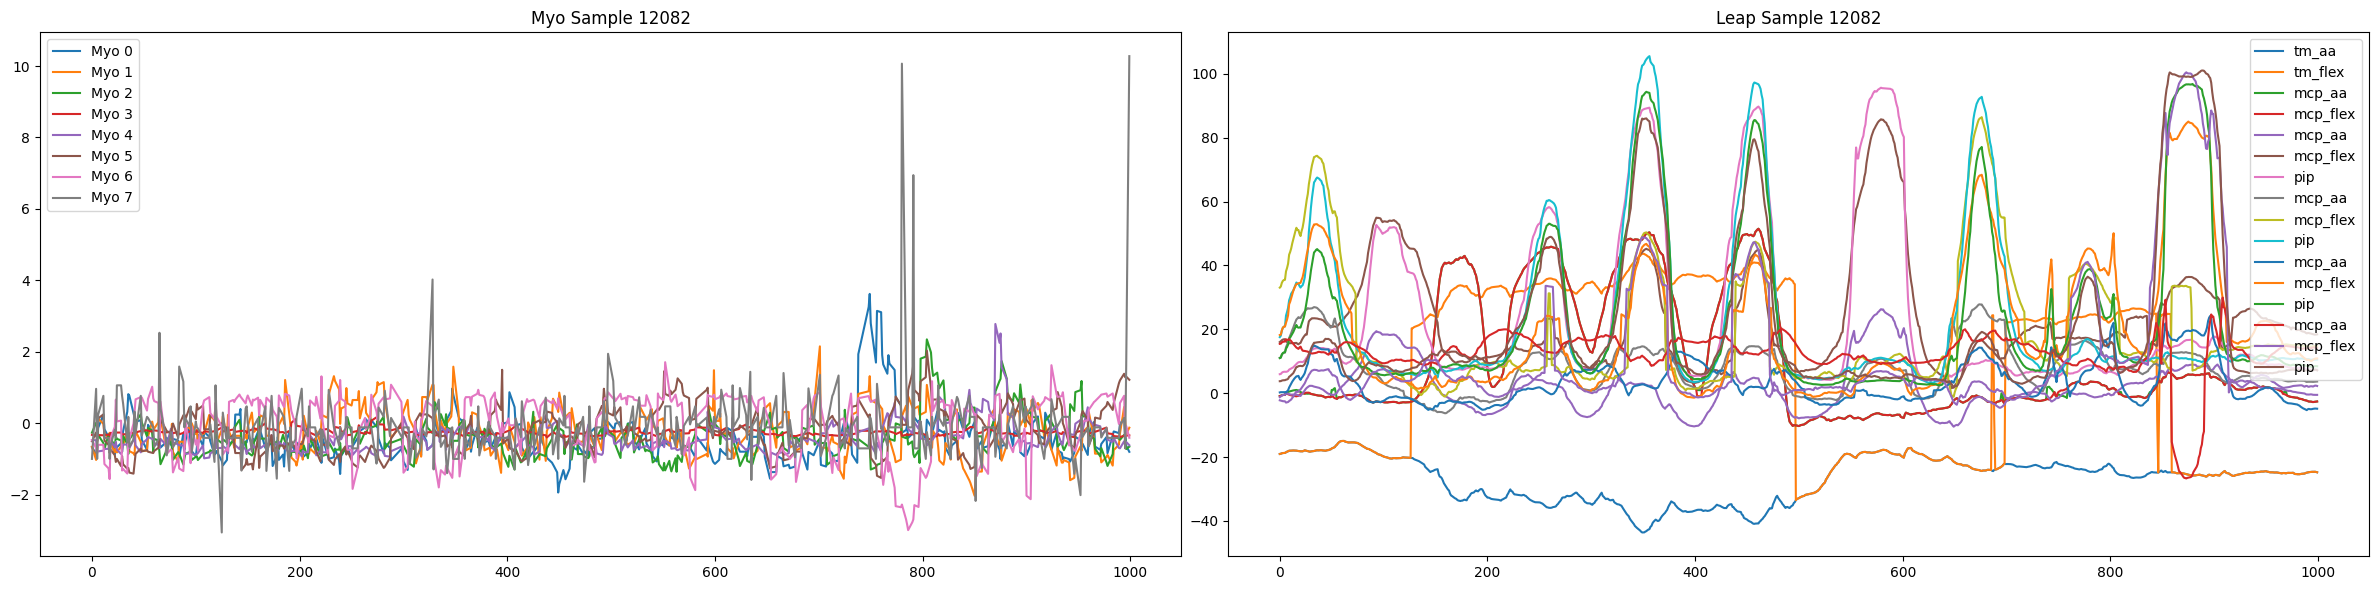

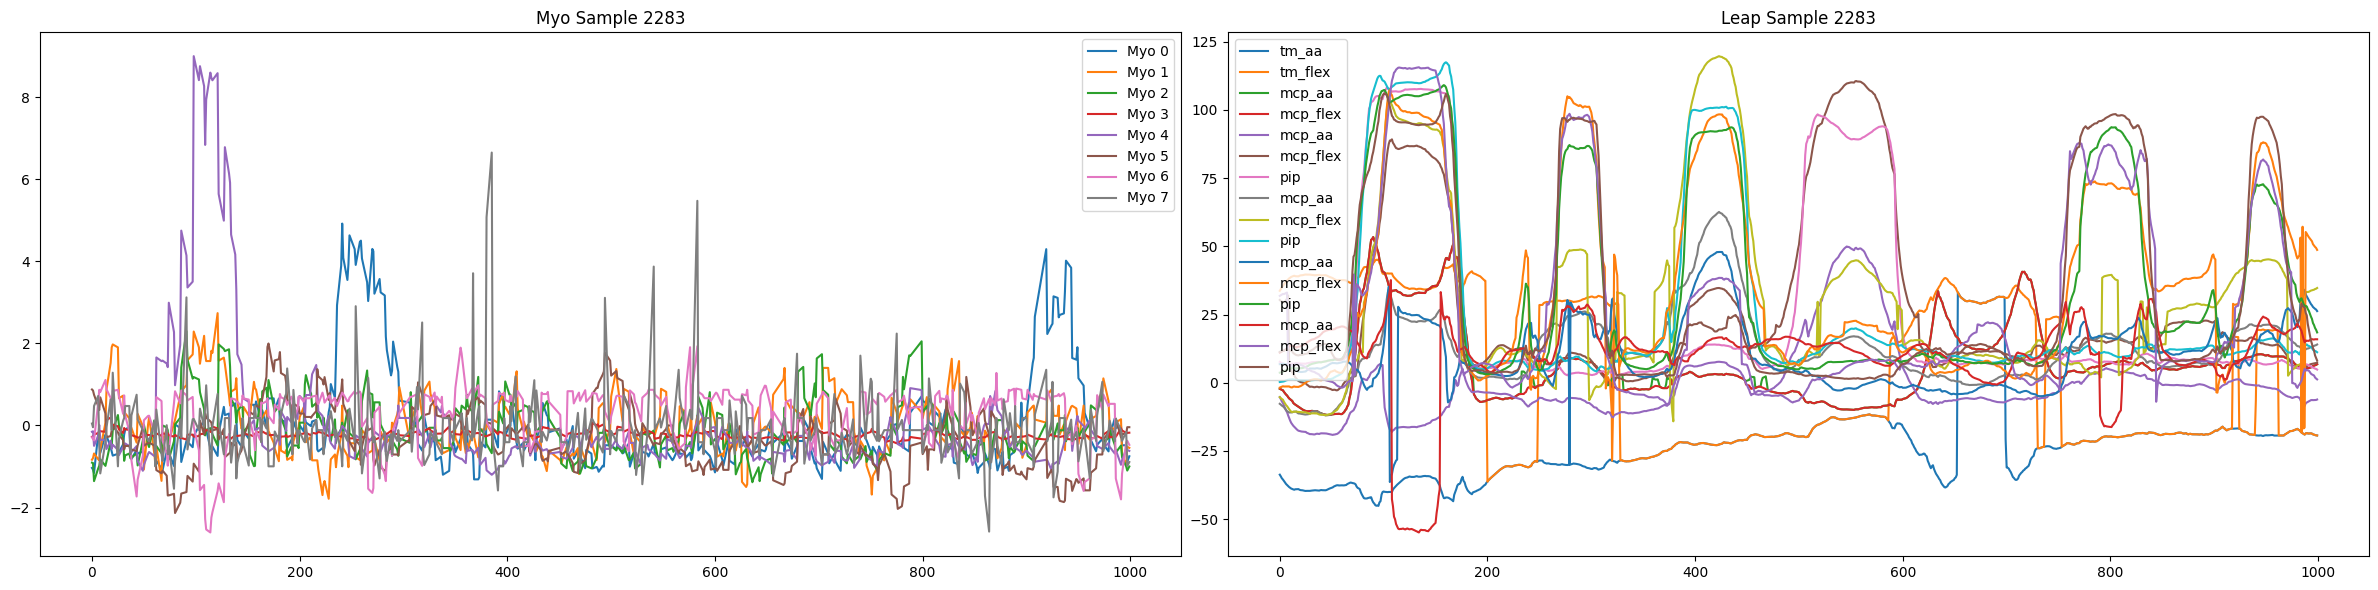

In [9]:
if DEBUG:
  # root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo4_env_clean"
  root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo8_env_clean"
  myo_dataset = MyoCombinedDataset(
    root_dir=root_dir,
    num_files=1,
    split="train",
  )

  print(myo_dataset[1])

  sample = myo_dataset[1]
  print(sample['myo'].shape)
  print(sample['leap'].shape)

  m = myo_dataset.get_min_max_leap([0,1,2,3])
  print(m)

  sample_nums = [random.randint(0,len(myo_dataset)) for _ in range(3)]
  for j, sample_num in enumerate(sample_nums):
    sample = myo_dataset[sample_num]
    plot_sample(sample, sample_num)

  plt.show()

# Model

In [10]:
class Model_Config():
  def __init__(self, leap_thumb_min_max=None):
    self.feature_num = 8
    self.seq_len = 250

    self.emb_norm = True

    self.hidden = 72
    self.hidden_ff = 144
    self.n_layers = 4
    # self.n_heads = 2
    self.n_heads = 4

    # self.mlp_hidden_dim = 512
    self.mlp_hidden_dim = 1024
    # self.mlp_hidden_dim = 2048
    self.mlp_dropout_prob = 0.0

    self.apply_constraints = True
    self.leap_thumb_min_max = leap_thumb_min_max
    self.output_features = 16

model_cfg = Model_Config()

## Custom Embedding

In [11]:
# Stolen from LIMU-BERT and modified
def gelu(x):
    "Implementation of the gelu activation function by Hugging Face"
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class LayerNorm(nn.Module):
    "A layernorm module in the TF style (epsilon inside the square root)."
    def __init__(self, cfg, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(cfg.hidden), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(cfg.hidden), requires_grad=True)
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class Embeddings(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_norm = cfg.emb_norm

        self.cls_token = nn.Parameter(torch.randn(1, 1, 1, cfg.hidden))
        # NOTE: Consider using cosine/sine positional embeddings
        # The +1 for the cls_token
        self.pos_embed = nn.Embedding(cfg.seq_len + 1, cfg.hidden)

        # Layers
        self.lin = nn.Linear(cfg.feature_num, cfg.hidden)
        self.norm = LayerNorm(cfg)

    def forward(self, x):
        batch_size, seq_len, *_ = x.size()
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(0).expand(batch_size, seq_len) # (S,) -> (B, S)

        # Factorized Embedding
        e = self.lin(x)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        # print(f"e shape: {e.shape}")
        # print(f"cls_tokens shape: {cls_tokens.shape}")

        if self.emb_norm:
            e = self.norm(e)

        e = torch.cat((cls_tokens, e), dim=2)
        e = e + self.pos_embed(pos)
        return self.norm(e)

embed = Embeddings(model_cfg)
print(embed)

Embeddings(
  (pos_embed): Embedding(251, 72)
  (lin): Linear(in_features=8, out_features=72, bias=True)
  (norm): LayerNorm()
)


## Constraint Layer

In [12]:
class BoundedReLU(nn.Module):
    def __init__(self, lower_bound=0, upper_bound=1):
        super().__init__()
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

    def forward(self, x):
        return torch.clamp(torch.nn.functional.relu(x), self.lower_bound, self.upper_bound)

class NeuroPoseOutputNorm(nn.Module):
  def __init__(self, leap_thumb_min_max):
    super(NeuroPoseOutputNorm, self).__init__()
    self.leap_thumb_min_max = leap_thumb_min_max

    self.mcp_aa_inds = [4, 7, 10, 13]
    self.mcp_flex_inds = [5, 8, 11, 14]
    self.pip_inds = [6, 9, 12, 15]

    self.mcp_aa_bound = [-15, 15]
    self.pip_bound = [0, 110]

    self.bRelu = BoundedReLU()
    self.k_bRelu = BoundedReLU(0, 0.5)

  def forward(self, x):
    # Avoid in-place modifications
    x_out = x.clone()

    # # Min-max normalization for thumb angles
    for i, min_max in self.leap_thumb_min_max.items():
      # x_out[:,i] = ((F.sigmoid(x[:,i]) - 0) * (min_max[1] - min_max[0])) / (1) + min_max[0]
      x_out[:,:,i] = ((F.sigmoid(x[:,:,i]) - 0) * (min_max[1] - min_max[0])) / (1) + min_max[0]

    # Safe normalization with small epsilon to prevent division by zero
    eps = 1e-8

    # MCP Abduction-Adduction Normalization
    # normed_mcp_aa = self.bRelu(x_out[:,self.mcp_aa_inds] / (self.mcp_aa_bound[1] + eps)) * self.mcp_aa_bound[1]
    normed_mcp_aa = self.bRelu(x_out[:,:,self.mcp_aa_inds] / (self.mcp_aa_bound[1] + eps)) * self.mcp_aa_bound[1]

    # PIP Normalization
    # normed_pip = self.bRelu(x_out[:,self.pip_inds] / (self.pip_bound[1] + eps)) * self.pip_bound[1]
    normed_pip = self.bRelu(x_out[:,:,self.pip_inds] / (self.pip_bound[1] + eps)) * self.pip_bound[1]

    # Safe k calculation with additional safeguards
    # k = x_out[:,self.mcp_flex_inds] / (normed_pip + eps)
    k = x_out[:,:,self.mcp_flex_inds] / (normed_pip + eps)
    k = self.k_bRelu(k)
    normed_mcp_flex = k * normed_pip

    # Update output tensor
    x_out[:,:,self.mcp_aa_inds] = normed_mcp_aa
    x_out[:,:,self.mcp_flex_inds] = normed_mcp_flex
    x_out[:,:,self.pip_inds] = normed_pip
    # x_out[:,self.mcp_aa_inds] = normed_mcp_aa
    # x_out[:,self.mcp_flex_inds] = normed_mcp_flex
    # x_out[:,self.pip_inds] = normed_pip

    return x_out

## Custom Loss

In [13]:
class NeuroPoseLoss(nn.Module):
  def __init__(self):
    super(NeuroPoseLoss, self).__init__()
    self.prev_pred = None

  def forward(self, output, target):
    mcp_aa_inds = [4, 7, 10, 13]
    mcp_flex_inds = [5, 8, 11, 14]
    pip_inds = [6, 9, 12, 15]

    loss_mcp_aa = 0
    for i in mcp_aa_inds:
      loss_mcp_aa += torch.pow((output[:,:,i] - target[:,:,i]), 2)
      # loss_mcp_aa += torch.pow((output[:,i] - target[:,i]), 2)
    loss_mcp_aa = torch.mean(loss_mcp_aa)

    loss_mcp_fe = 0
    for i in mcp_flex_inds:
      loss_mcp_fe += torch.pow((output[:,:,i] - target[:,:,i]), 2)
      # loss_mcp_fe += torch.pow((output[:,i] - target[:,i]), 2)
    loss_mcp_fe = torch.mean(loss_mcp_fe)

    loss_pip_fe = 0
    for i in pip_inds:
      loss_pip_fe += torch.pow((output[:,:,i] - target[:,:,i]), 2)
      # loss_pip_fe += torch.pow((output[:,i] - target[:,i]), 2)
    loss_pip_fe = torch.mean(loss_pip_fe)

    # loss_thumb_tm_aa = torch.mean(torch.pow(output[:,0] - target[:,0], 2))
    # loss_thumb_tm_fe = torch.mean(torch.pow(output[:,1] - target[:,1], 2))
    # loss_thumb_mcp_aa = torch.mean(torch.pow(output[:,2] - target[:,2], 2))
    # loss_thumb_mcp_fe = torch.mean(torch.pow(output[:,3] - target[:,3], 2))
    loss_thumb_tm_aa = torch.mean(torch.pow(output[:,:,0] - target[:,:,0], 2))
    loss_thumb_tm_fe = torch.mean(torch.pow(output[:,:,1] - target[:,:,1], 2))
    loss_thumb_mcp_aa = torch.mean(torch.pow(output[:,:,2] - target[:,:,2], 2))
    loss_thumb_mcp_fe = torch.mean(torch.pow(output[:,:,3] - target[:,:,3], 2))

    loss_thumb = (loss_thumb_mcp_aa + loss_thumb_mcp_fe + loss_thumb_tm_aa + loss_thumb_tm_fe)/4

    if self.prev_pred is None:
      loss_smoothness = 0
    else:
      loss_smoothness = torch.sum(torch.pow(output.grad - self.prev_pred.grad, 2))
      self.prev_pred = output

    loss = (loss_mcp_aa + loss_mcp_fe + loss_pip_fe + loss_thumb + loss_smoothness) / 5

    return loss

# Get LIMU-BERT

In [14]:
!git clone https://github.com/dapowan/LIMU-BERT-Public.git
%cd LIMU-BERT-Public/

fatal: destination path 'LIMU-BERT-Public' already exists and is not an empty directory.
/content/LIMU-BERT-Public


In [15]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Create Modified Model and Load Pretrained Weights

In [16]:
from models import Transformer, LIMUBertModel4Pretrain, \
MultiHeadedSelfAttention, PositionWiseFeedForward
from config import PretrainModelConfig


class MyoTransformer(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.my_embed = Embeddings(cfg)

    # To used parameter-sharing strategies
    self.n_layers = cfg.n_layers

    self.attn = MultiHeadedSelfAttention(cfg)
    self.proj = nn.Linear(cfg.hidden, cfg.hidden)
    self.norm1 = LayerNorm(cfg)
    self.pwff = PositionWiseFeedForward(cfg)
    self.norm2 = LayerNorm(cfg)

  def forward(self, x):
    h = self.my_embed(x)

    for _ in range(self.n_layers):
      h = self.attn(h)
      h = self.norm1(h + self.proj(h))
      h = self.norm2(h + self.pwff(h))
    return h

class MLP(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg

    # self.lin1 = nn.Linear(8128, cfg.mlp_hidden_dim)
    self.lin1 = nn.Linear(cfg.hidden, cfg.mlp_hidden_dim)
    self.lin2 = nn.Linear(cfg.mlp_hidden_dim, cfg.output_features)
    self.dropout = nn.Dropout(cfg.mlp_dropout_prob)

  def forward(self, x):
    x = self.lin1(x)
    x = gelu(x)
    x = self.lin2(x)
    x = self.dropout(x)
    return x

class CNN_Head(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.cfg = cfg

    in_channels = [32, 16, 8, 4]
    out_channels = [16, 8, 4, 1]
    layers = []
    for i in range(4):
      layers += [
          nn.Conv2d(in_channels[i], out_channels[i], [32,3], padding=0),
          nn.BatchNorm2d(out_channels[i]),
          nn.ReLU(),
          nn.Dropout(0.05),
      ]
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

class ClassifierAttn(nn.Module):
  def __init__(self, cfg, input=None, output=None):
    super().__init__()
    self.embd = nn.Embedding(250, input)
    self.proj_q = nn.Linear(input, 36)
    self.proj_k = nn.Linear(input, 36)
    self.proj_v = nn.Linear(input, 36)
    self.attn = nn.MultiheadAttention(36, 4)
    # self.linear = nn.Linear(720, 512)
    self.linear = nn.Linear(9036, 512)
    self.linear2 = nn.Linear(512, 16)

    self.dropout = nn.Dropout(0.05)
    self.flatten = nn.Flatten()

  def forward(self, input_seqs, training=False):
    seq_len = input_seqs.size(1)
    pos = torch.arange(seq_len, dtype=torch.long, device=input_seqs.device)
    pos = pos.unsqueeze(0).expand(input_seqs.size(0), seq_len)  # (S,) -> (B, S)
    # h = input_seqs + self.embd(pos)
    h = input_seqs
    q = self.proj_q(h)
    k = self.proj_k(h)
    v = self.proj_v(h)
    q = torch.mean(q, dim=1)
    k = torch.mean(k, dim=1)
    v = torch.mean(v, dim=1)
    # print(f"q shape: {q.shape}")
    # print(f"k shape: {k.shape}")
    # print(f"v shape: {v.shape}")
    h, weights = self.attn(q, k, v)

    h = self.dropout(h)
    # print(f"h shape: {h.shape}")
    h = self.flatten(h)
    # print(f"flat shape: {h.shape}")
    h = self.linear(h)
    h = F.relu(h)
    h = self.linear2(h)
    return h

class MyoLimuBert(nn.Module):
  def __init__(self, cfg, old_cfg_path, pretrained_model_path):
    super().__init__()
    self.cfg = cfg

    old_cfg = PretrainModelConfig.from_json(json.load(open(old_cfg_path, 'r'))['base_v1'])
    self.load_state_dict(torch.load(pretrained_model_path, weights_only=True, map_location=device), strict=False)

    self.transformer = MyoTransformer(cfg)
    self.mlp = MLP(cfg)
    if cfg.apply_constraints:
      self.norm = NeuroPoseOutputNorm(cfg.leap_thumb_min_max)

  def forward(self, x):
    x = self.transformer(x)

    # cls = x[:, 0, :]
    # logits = self.mlp(cls)
    # print(f"transformer shape : {x.shape}")
    logits = self.mlp(x)
    if self.cfg.apply_constraints:
      # print(f"prenorm shape : {logits.shape}")
      logits = self.norm(logits)

    return logits

class MyoBert(nn.Module):
  def __init__(self, cfg, old_cfg_path, pretrained_model_path):
    super().__init__()
    self.cfg = cfg

    old_cfg = PretrainModelConfig.from_json(json.load(open(old_cfg_path, 'r'))['base_v1'])
    self.load_state_dict(torch.load(pretrained_model_path, weights_only=True, map_location=device), strict=False)

    self.transformer = MyoTransformer(cfg)
    self.classifier_head = ClassifierAttn(cfg, input=72, output=16)
    if cfg.apply_constraints:
      self.norm = NeuroPoseOutputNorm(cfg.leap_thumb_min_max)

  def forward(self, x):
    x = self.transformer(x)
    x = self.classifier_head(x)
    if self.cfg.apply_constraints:
      x = self.norm(x)
    return x



In [17]:
# from torch.profiler import profile, record_function, ProfilerActivity

# seed_everything(0)

# cfg = Model_Config()
# path_bert = "/content/LIMU-BERT-Public/config/limu_bert.json"
# model = MyoLimuBert(cfg, path_bert, PATH)

# model.train()
# model.to(device)

# # Initialize dataset
# root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo8_env_clean"

# num_files = 1
# num_samples_per_window = 250
# train_data = MyoCombinedDataset(
#   root_dir=root_dir,
#   num_files=num_files,
#   split="train",
#   num_samples_per_window=num_samples_per_window,
#   stride=1
# )

# thumb_idxs = [0,1,2,3]
# leap_thumb_min_max = train_data.get_min_max_leap(thumb_idxs)
# print(f"\nThumb Min Max: {leap_thumb_min_max}")

# # Define the batch size and number of workers
# batch_size = 32
# # batch_size = 128
# num_workers = 2

# # Define the data loaders
# train_loader = torch.utils.data.DataLoader(
#     train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# for i, loader in enumerate(train_loader):
#   inputs = loader['myo'].to(device)
#   labels = loader['leap'].to(device)

#   activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU]
#   with profile(activities=activities, profile_memory=True, record_shapes=True) as prof:
#       model(inputs)

#   if i == 0:
#     break

# prof.export_chrome_trace("trace.json")


# print(prof.key_averages().table(row_limit=10))
# # print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))


# Training Function


In [18]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, scheduler=None, plot=True):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    start_time = time.time()

    STEP_SAVE_COUNT = 100
    training_loss_list = []
    validation_loss_list = []

    try:
      for epoch in range(num_epochs):
          step_loss = []
          model.train()  # Set model to training mode

          # Use tqdm to display a progress bar during training
          with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for i, loader in enumerate(train_loader):
              # Move inputs and labels to device
              inputs = loader['myo'].to(device)
              labels = loader['leap'].to(device)

              # print(f"inputs shape: {inputs.shape}")
              # print(f"labels shape: {labels.shape}")

              # Zero out gradients
              optimizer.zero_grad()

              # Compute the logits and loss
              logits = model(inputs)

              # cls = logits[:,0,:]
              # loss = criterion(cls, labels[:,0,125,:])

              # loss = criterion(logits[:,:,1:,:], labels[:,:,:,:])

              # HERE WORKS
              # loss = criterion(logits[:,:,1,:], labels[:,:,0,:])
              # loss = criterion(logits[:,:,126,:], labels[:,:,125,:])

              loss = criterion(logits, labels[:,0,0,:])
              # print(f"cls shape: {cls.shape}")
              # print(f"Loss: {loss}")

              # Backpropagate the loss
              loss.backward()

              # Update the weights and LR scheduler
              optimizer.step()
              step_loss.append(loss.item())

              # Add to training loss list
              # if i % STEP_SAVE_COUNT == 0:
              #   training_loss_list.append(loss.item())

              # Update the progress bar
              pbar.update(1)
              pbar.set_postfix(loss=loss.item())

            if scheduler is not None:
              scheduler.step()



          # Evaluate the model on the validation set
          avg_loss, accuracy, val_loss = evaluate(model, val_loader, criterion, device, STEP_SAVE_COUNT)

          training_loss_list.append(np.array(step_loss).mean())
          validation_loss_list.append(avg_loss)

          # print(f"inputs: {inputs[0,0,0,:]}")
          # print(f"logits: {logits[0,0,0,:]}")
          # print(f"labels: {labels[0,0,0,:]}")
          cur_time = time.time()
          print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}, Elapsed Time = {int((cur_time - start_time)//60)} min  {int((cur_time - start_time)%60)} sec')
    except KeyboardInterrupt:
      print("\nTraining Interrupted")
    if plot:
      plt.plot(training_loss_list, label="Training Loss")
      plt.plot(validation_loss_list, label="Eval Loss")
      plt.legend()
      plt.xlabel("Epoch")
      plt.show()

    return training_loss_list, validation_loss_list

def evaluate(model, test_loader, criterion, device, step_save_count):
    """
    Args:
        model: The model to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode
    val_loss = []

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for i, (loader) in enumerate(test_loader):
            # Move inputs and labels to device
            inputs = loader['myo'].to(device)
            labels = loader['leap'].to(device)

            # Compute the logits and loss
            logits = model(inputs)
            # loss = criterion(logits, labels)

            # cls = logits[:,0,:]
            # loss = criterion(cls, labels[:,0,125,:])
            # loss = criterion(logits[:,:,1:,:], labels[:,:,:,:])
            loss = criterion(logits, labels[:,0,0,:])
            # loss = criterion(logits[:,:,126,:], labels[:,:,125,:])

            # HERE WORKS
            # loss = criterion(logits[:,:,1,:], labels[:,:,0,:])

            total_loss += loss.item()

            # TODO: Modify the accuracy calculation for our non-classification task.
            #   It is closer to image segmentation than image classification.
            # Compute the accuracy
            # _, predictions = torch.max(logits, dim=1)
            # num_correct += (predictions == labels).sum().item()
            # num_samples += len(inputs)

            # Add to Val loss?
            if i % step_save_count == 0:
              val_loss.append(loss.item())

    print(logits.shape)
    print(logits[0,:])
    # print(logits[0,0,126,:])
    # print(logits[0,0,:])
    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    # accuracy = num_correct / num_samples
    accuracy = 0

    return avg_loss, accuracy, val_loss

# New Training Stuffs

## Joint Error Boxplots

In [19]:
def calc_angle_err(logits, labels):
  batch_feature_errs = []
  # print(f"logits shape: {logits.shape}")
  # print(f"labels shape: {labels.shape}")
  for batch_idx in range(labels.shape[0]):
    angle_errs_per_batch = []
    for feature_idx in range(labels.shape[-1]):
      # Extract feature-specific outputs and targets
      # feature_output = logits[batch_idx, feature_idx]
      # feature_target = labels[batch_idx, feature_idx]
      feature_output = logits[batch_idx, :, feature_idx]
      feature_target = labels[batch_idx, :, feature_idx]
      # feature_output = logits[batch_idx, :, :, feature_idx]
      # feature_target = labels[batch_idx, :, :, feature_idx]

      # Calculate Angle Error in degrees
      angle_errs_per_batch.append(torch.mean(torch.abs(feature_output - feature_target)).item())
    batch_feature_errs.append(angle_errs_per_batch)

  return batch_feature_errs

In [20]:
def generate_err_boxplot(err_array, title="Finger Joint Error Distribution"):
  """
  Generate a boxplot of error in degrees for each finger joint feature

  Parameters:
  - err_array: NumPy array of error in degrees values with shape [num_batches, num_features]
  """

  num_fingers = 4
  feature_names = ["tm_aa", "tm_flex", "mcp_aa", "mcp_flex"]
  for i in range(num_fingers):
    feature_names += ["mcp_aa", "mcp_flex", "pip"]

  finger_names = ["Thumb", "Index", "Middle", "Ring", "Pinky"]

  fig, ax = plt.subplots(layout='constrained', figsize=(7, 4))
  bplot = plt.boxplot(err_array,
                     showfliers=False,
                     patch_artist=True,
                     whis=1.9,
                     boxprops=dict(facecolor="skyblue"),
                     medianprops=dict(color="skyblue"))


  ax.set_title(title)
  ax.set_ylabel('Error in Degrees')

  ax.set_ylim(bottom=0)

  sec = ax.secondary_xaxis(location=0)
  sec.set_xticks([2.5, 6, 9, 12, 15], labels=[f"\n\n\n\n\n{n}" for n in finger_names])
  sec.tick_params('x', length=0, width=0)

  sec2 = ax.secondary_xaxis(location=0)
  sec2.set_xticks([0, 4.5, 7.5, 10.5, 13.5, 16.5], labels=[])
  sec2.tick_params('x', length=40, width=1)

  ax.set_xticklabels(feature_names, rotation=65)
  plt.show()

## Trainer Class

In [21]:
class Trainer(object):
  """Training Helper Class"""
  def __init__(self, cfg, model, optimizer, criterion, save_path, device, save_best_worst=False, scheduler=None):
    self.cfg = cfg # config for training : see class Config
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.save_path = save_path
    self.device = device # device name
    self.scheduler = scheduler
    self.save_best_worst = save_best_worst

    self.training_loss_list = []
    self.validation_loss_list = []

    self.best = {
        "input": None,
        "logits": None,
        "labels": None,
        "loss": 1e8
    }

    self.worst = self.best.copy()
    self.worst["loss"] = -1

  def train(self, train_loader, val_loader, plot=True):
    # Place model on device
    model = self.model.to(self.device)

    global_step = 0 # global iteration steps regardless of epochs

    start_time = time.time()

    self.training_loss_list = []
    self.validation_loss_list = []

    try:
      for epoch in range(self.cfg["num_epochs"]):
          step_loss = []
          total_step_loss = 0.0
          model.train()  # Set model to training mode

          loss_sum = 0. # the sum of iteration losses to get average loss in every epoch
          time_sum = 0.0

          # Use tqdm to display a progress bar during training
          with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{self.cfg["num_epochs"]}') as pbar:
            for i, loader in enumerate(train_loader):
              start_time = time.time()

              # Move inputs and labels to device
              inputs = loader['myo'].to(self.device)
              labels = loader['leap'].to(self.device)

              # Zero out gradients
              self.optimizer.zero_grad()

              # Compute the logits and loss
              logits = model(inputs)
              # loss = self.criterion(logits, labels)

              # loss = self.criterion(logits, labels[:,0,0,:])

              loss = self.criterion(logits[:,:,126,:], labels[:,:,125,:])

              # Backpropagate the loss
              loss.backward()

              # Update the weights and LR scheduler
              self.optimizer.step()
              total_step_loss += loss.item()
              # step_loss.append(loss.item())

              # Update the progress bar
              pbar.update(1)
              pbar.set_postfix(loss=loss.item())

              # if i == 0:
              #   break

            if self.scheduler is not None:
              self.scheduler.step()

          # Evaluate the model on the validation set, plotting angle error box
          #   plot every 5 epochs
          if (epoch+1) %5 != 0:
          # if (epoch+0) %5 != 0:
            avg_loss = self.evaluate(val_loader)
          else:
            avg_loss = self.evaluate(val_loader, True)
          model.train()

          self.training_loss_list.append(total_step_loss / len(train_loader))
          self.validation_loss_list.append(avg_loss)

          print(f"Validation loss: {avg_loss}")
          if avg_loss < self.best["loss"]:
            print("saved new best model")
            self.best["input"] = inputs
            self.best["logits"] = logits
            self.best["labels"] = labels
            self.save(0)

    except KeyboardInterrupt:
      print("\nTraining Interrupted")
      _ = self.evaluate(val_loader, True)

    if plot:
      self.plot_loss()

    return self.training_loss_list, self.validation_loss_list

  def evaluate(self, val_loader, plot_boxplot=False):
    model = self.model.eval()  # Set model to evaluation mode
    angle_errs = []

    with torch.no_grad():
      total_loss = 0.0
      num_correct = 0
      num_samples = 0

      for i, (loader) in enumerate(val_loader):
        # Move inputs and labels to device
        inputs = loader['myo'].to(self.device)
        labels = loader['leap'].to(self.device)

        # Compute the logits and loss
        logits = model(inputs)
        # loss = self.criterion(logits, labels)
        # loss = self.criterion(logits, labels[:,0,0,:])

        loss = self.criterion(logits[:,:,126,:], labels[:,:,125,:])
        total_loss += loss.item()

        if plot_boxplot:
          angle_errs.extend(calc_angle_err(logits[:,:,126,:], labels[:,:,125,:]))
          # angle_errs.extend(calc_angle_err(logits, labels[:,0,0,:]))
          # angle_errs.extend(calc_angle_err(logits, labels))

        if self.save_best_worst and (i == 0 or loss > self.worst["loss"]):
          self.worst["input"] = inputs
          self.worst["logits"] = logits
          self.worst["labels"] = labels
          self.worst["loss"] = loss

        if self.save_best_worst and (i == 0 or loss < self.best["loss"]):
          print("Saving best model_dict from validation")
          self.best["input"] = inputs
          self.best["logits"] = logits
          self.best["labels"] = labels
          self.best["loss"] = loss
          self.save(0)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(val_loader)

    if plot_boxplot:
      angle_errs = np.array(angle_errs)
      generate_err_boxplot(angle_errs)

    return avg_loss


  def plot_loss(self):
    """ Plot training and validation loss """
    plt.plot(self.training_loss_list, label="Training Loss")
    plt.plot(self.validation_loss_list, label="Eval Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

  def load(self, model_file, load_self=False):
    """ load saved model or pretrained transformer (a part of model) """
    if model_file:
      print('Loading the model from', model_file)
      if load_self:
        self.model.load_self(model_file + '.pt', map_location=self.device)
      else:
        self.model.load_state_dict(torch.load(model_file + '.pt', map_location=self.device))

  def save(self, i=0):
    """ save current model """
    if i != 0:
      torch.save(self.model.state_dict(), self.save_path + "_" + str(i) + '.pt')
    else:
      torch.save(self.model.state_dict(),  self.save_path + '.pt')


In [22]:
seed_everything(0)

# Initialize dataset
root_dir = "/content/drive/MyDrive/2 ECEM202A Embedded System/Data/myo8_env_clean"

num_files = 1
num_samples_per_window = 250
train_data = MyoCombinedDataset(
  root_dir=root_dir,
  num_files=num_files,
  split="train",
  num_samples_per_window=num_samples_per_window,
  stride=1
)

thumb_idxs = [0,1,2,3]
leap_thumb_min_max = train_data.get_min_max_leap(thumb_idxs)
print(f"\nThumb Min Max: {leap_thumb_min_max}")

test_data = MyoCombinedDataset(
  root_dir=root_dir,
  num_files=num_files,
  split="test",
  num_samples_per_window=num_samples_per_window,
  stride=1
)

Dataset created
torch.Size([14838, 250, 8])
torch.Size([14838, 250, 16])

Thumb Min Max: {0: [tensor(-55.9820), tensor(53.1180)], 1: [tensor(-48.1660), tensor(55.9820)], 2: [tensor(-33.5360), tensor(53.3910)], 3: [tensor(-18.3340), tensor(53.3910)]}
Dataset created
torch.Size([3710, 250, 8])
torch.Size([3710, 250, 16])


# Init Model

## Define Hyperparameters

In [23]:
# Initialize Neuropose Model
PATH = "/content/LIMU-BERT-Public/saved/pretrain_base_motion_20_120/motion.pt"
path_bert = "/content/LIMU-BERT-Public/config/limu_bert.json"

cfg = Model_Config(leap_thumb_min_max)
# model = MyoBert(cfg, path_bert, PATH)
model = MyoLimuBert(cfg, path_bert, PATH)

# Define the Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,
    amsgrad=False
)

# Define the batch size and number of workers
# batch_size = 64
batch_size = 48
# batch_size = 32
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
# criterion = nn.MSELoss()
criterion = NeuroPoseLoss()

## Run a single batch

In [24]:
from torch.profiler import profile, record_function, ProfilerActivity

# print(model)
model.train()
model.to(device)

for i, loader in enumerate(train_loader):
  inputs = loader['myo'].to(device)
  labels = loader['leap'].to(device)

  # Compute the logits and loss
  print(f"Inputs shape: {inputs.shape}")

  activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU]
  with profile(activities=activities, profile_memory=True, record_shapes=True) as prof:
    logits = model(inputs)

  print("\n")

  print(f"Logits shape: {logits.shape}")
  print(f"Labels shape: {labels.shape}")

  # print(f"inputs: {inputs[0,0,0,:]}")
  # print(f"logits: {logits[0,0,125,:]}")
  print(f"labels: {labels[0,0,125,:]}")

  # cls = logits[:,0,:]
  # print(f"cls shape: {cls.shape}")
  # print(f"cls sample: {cls[0,:]}")

  # loss = criterion(cls, labels[:,0,125,:])

  loss = criterion(logits[:,:,126,:], labels[:,:,125,:])
  # loss = criterion(logits, labels[:,0,0,:])
  print(f"Loss: {loss}")

  loss.backward()
  optimizer.step()

  if i == 0:
    break

# prof.export_chrome_trace("trace.json")
print(prof.key_averages().table(row_limit=20))

Inputs shape: torch.Size([48, 1, 250, 8])


Logits shape: torch.Size([48, 48, 251, 16])
Labels shape: torch.Size([48, 1, 250, 16])
labels: tensor([-20.7880, -20.7880,  -3.6940,  -3.6940,  -7.5010,   6.8340,   4.5550,
         -7.5440,   3.1500,   4.5880, -10.0340,   0.2660,   3.1920,  15.0340,
         -1.7120,   4.3280], device='cuda:0')
Loss: 2655.89208984375
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------ 

## Train Model

Epoch 1/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.67e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1811.9879150390625


Epoch 2/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=3.75e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1684.6533860426682


Epoch 3/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=989]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1625.2100564027444


Epoch 4/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.88e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1578.5691833496094


Epoch 5/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.79e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


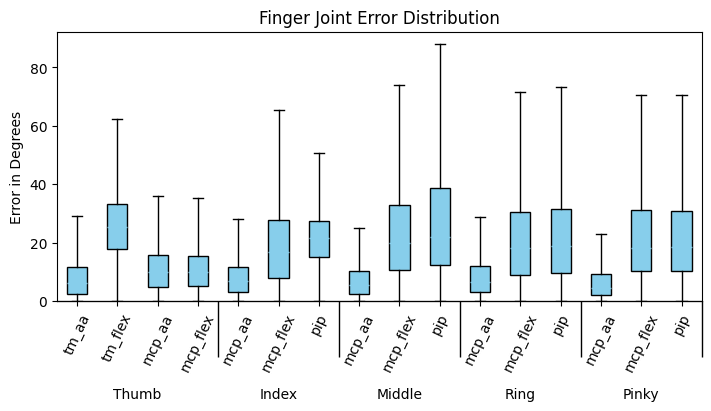

Validation loss: 1537.5474274464143


Epoch 6/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=697]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1471.690917186248


Epoch 7/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=844]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1540.9087798289763


Epoch 8/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.03e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1419.4932329226763


Epoch 9/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=853]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1375.2592390011519


Epoch 10/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.02e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


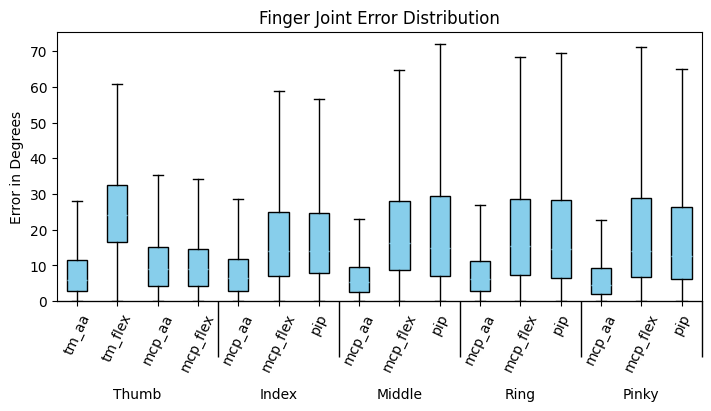

Validation loss: 1382.4848812787961


Epoch 11/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.54e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1310.1810138408955


Epoch 12/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=2.23e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1315.289283948067


Epoch 13/35: 100%|██████████| 310/310 [01:59<00:00,  2.60it/s, loss=1.51e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1260.3673588679387


Epoch 14/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.03e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1238.2368703988882


Epoch 15/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.03e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


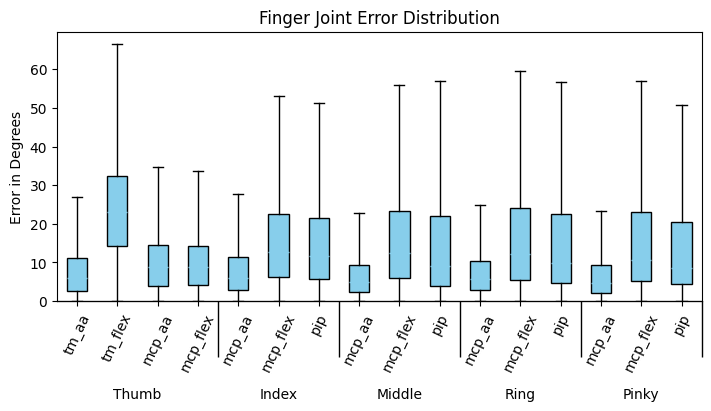

Validation loss: 1201.1198511368189


Epoch 16/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.74e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1134.504166040665


Epoch 17/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.42e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1108.5626760629507


Epoch 18/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.76e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1144.3498910757212


Epoch 19/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.54e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1102.9759341508914


Epoch 20/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.11e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


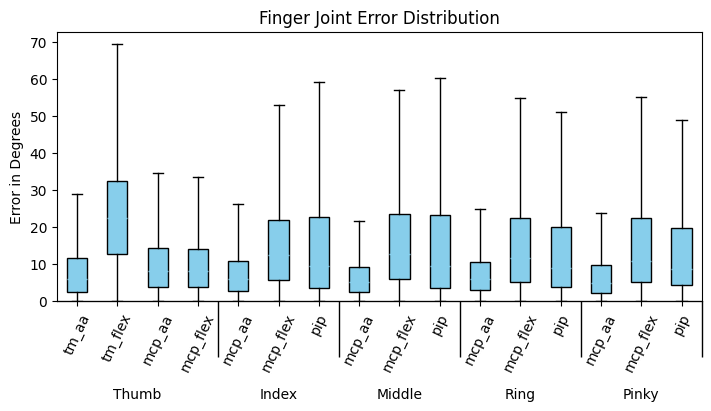

Validation loss: 1094.3665505433694


Epoch 21/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=563]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1059.8171089367988


Epoch 22/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.29e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 1001.0264712602665


Epoch 23/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.77e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 995.3002843612279


Epoch 24/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=282]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 961.7669646434294


Epoch 25/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=426]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


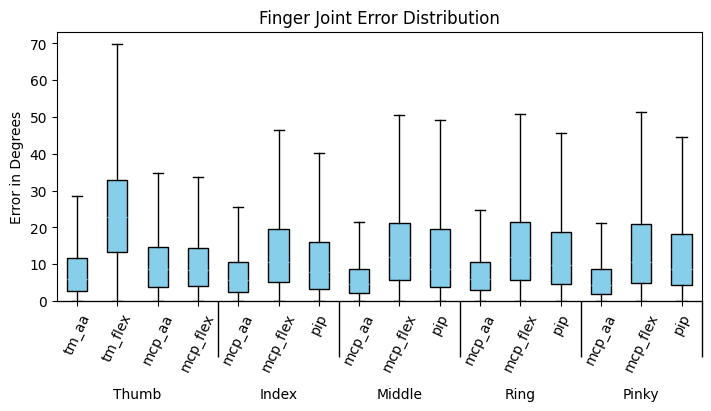

Validation loss: 964.7004081530449


Epoch 26/35: 100%|██████████| 310/310 [01:59<00:00,  2.60it/s, loss=652]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 935.6367453550681


Epoch 27/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=979]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 973.8998139210237


Epoch 28/35: 100%|██████████| 310/310 [01:59<00:00,  2.60it/s, loss=2.77e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 956.688969538762


Epoch 29/35: 100%|██████████| 310/310 [01:59<00:00,  2.60it/s, loss=1.88e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 930.6746004544772


Epoch 30/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=1.6e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


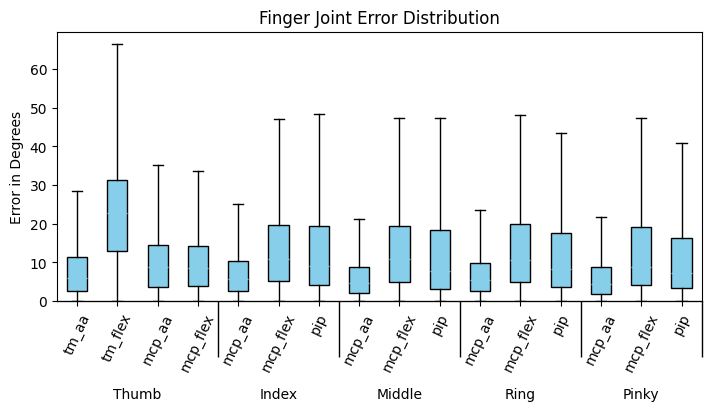

Validation loss: 899.6087231758313


Epoch 31/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=716]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 920.9234071389222


Epoch 32/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=2.82e+3]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 829.9274284167168


Epoch 33/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=743]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 854.2687424879807


Epoch 34/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=558]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Validation loss: 838.417715219351


Epoch 35/35: 100%|██████████| 310/310 [01:58<00:00,  2.61it/s, loss=810]


Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation
Saving best model_dict from validation


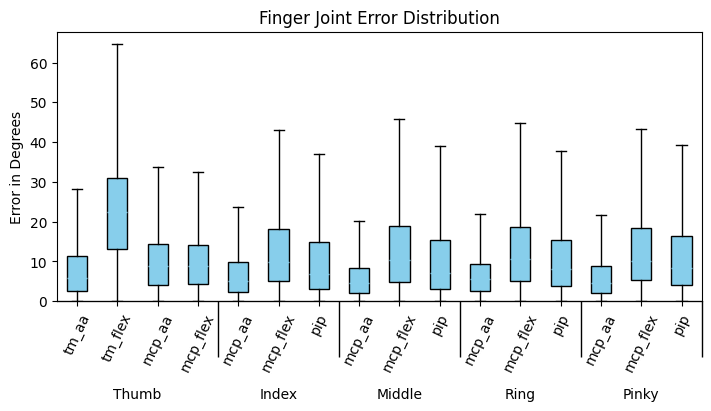

Validation loss: 822.4746524126102


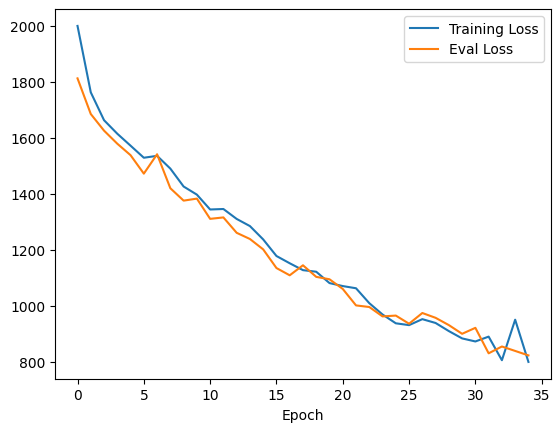

In [25]:
my_cfg = {
    "num_epochs": 35
}
save_path = "/content/saved_model_normed_myobert_l125"

trainer = Trainer(my_cfg, model, optimizer, criterion, save_path, device, save_best_worst=True)
training_loss_per_epoch, val_loss_per_epoch = trainer.train(train_loader, test_loader)


## Plot Results

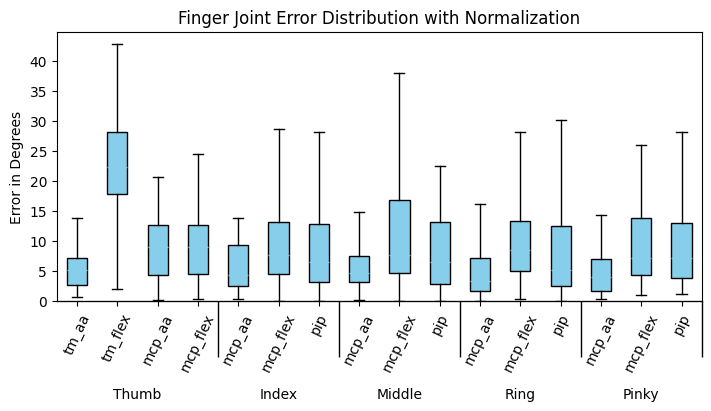

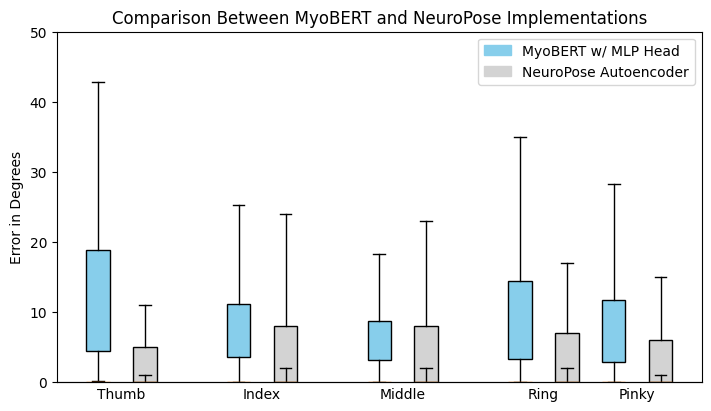

In [26]:
from matplotlib import cbook
from matplotlib import patches as mpatches

angle_errs = np.array(calc_angle_err(trainer.best["logits"][:,:,126,:], trainer.best["labels"][:,:,125,:]))
# angle_errs = np.array(calc_angle_err(trainer.best["logits"], trainer.best["labels"][:,0,0,:]))
generate_err_boxplot(angle_errs, "Finger Joint Error Distribution with Normalization")

finger_names = ["Thumb", "Index", "Middle", "Ring", "Pinky"]

myo_finger_errs = [
    np.concatenate(angle_errs[:, :4]),
    np.concatenate(angle_errs[:, 4:6]),
    np.concatenate(angle_errs[:, 6:8]),
    np.concatenate(angle_errs[:, 8:10]),
    np.concatenate(angle_errs[:, 10:])
  ]

myo_stats = cbook.boxplot_stats(myo_finger_errs, whis=1.9, labels=['' for _ in myo_finger_errs])
for i in range(5):
  myo_stats[i]['med'] = 0

neuropose_stats = [
    dict(med=0, q1=0, q3=5, whislo=1, whishi=11, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=24, fliers=[], label=''),
    dict(med=0, q1=0, q3=8, whislo=2, whishi=23, fliers=[], label=''),
    dict(med=0, q1=0, q3=7, whislo=2, whishi=17, fliers=[], label=''),
    dict(med=0, q1=0, q3=6, whislo=1, whishi=15, fliers=[], label=''),
  ]
neuropose_stats = np.array(neuropose_stats)

bxp_stats = []
for i in range(5):
  bxp_stats.append(myo_stats[i])
  bxp_stats.append(neuropose_stats[i])

grouped_positions = [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]

fig, ax = plt.subplots(layout='constrained', figsize=(7, 4))
bplot = ax.bxp(
    bxp_stats,
    positions=grouped_positions,
    showfliers=False,
    manage_ticks=False,
    patch_artist=True)

colors = []
for _ in range(5):
  colors.append("skyblue")
  colors.append("lightgrey")

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title("Comparison Between MyoBERT and NeuroPose Implementations")
ax.set_ylabel('Error in Degrees')
ax.set_xticks([])

myo_patch = mpatches.Patch(color="skyblue", label="MyoBERT w/ MLP Head")
neuro_patch = mpatches.Patch(color="lightgrey", label="NeuroPose Autoencoder")
ax.legend(handles=[myo_patch, neuro_patch])

plt.ylim(0, 50)

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([1.5, 4.5, 7.5, 10.5, 12.5], labels=[f"{n}" for n in finger_names])
sec.tick_params('x', length=0, width=0)

plt.show()

Epoch 1/25: 100%|██████████| 464/464 [01:09<00:00,  6.67it/s, loss=2.46e+3]


torch.Size([30, 16])
tensor([-23.7046,   8.0241,   2.8211,   5.3180,   0.0000,  14.9801,  29.9602,
          7.2519,  18.8317,  37.6635,   0.0000,  21.6021,  43.2042,  15.0000,
         15.1252,  30.2504], device='cuda:0')
Validation set: Average loss = 2242.7661, Accuracy = 0.0000, Elapsed Time = 1 min  16 sec


Epoch 2/25: 100%|██████████| 464/464 [01:09<00:00,  6.67it/s, loss=2.23e+3]


torch.Size([30, 16])
tensor([-20.9716,  -2.7615,   5.8369,   4.2173,   0.0000,   8.5389,  17.0778,
          3.5646,  13.4016,  26.8032,   0.0000,  15.8252,  31.6504,  15.0000,
         11.9466,  23.8931], device='cuda:0')
Validation set: Average loss = 2258.5829, Accuracy = 0.0000, Elapsed Time = 2 min  32 sec


Epoch 3/25: 100%|██████████| 464/464 [01:09<00:00,  6.67it/s, loss=2.09e+3]


torch.Size([30, 16])
tensor([-36.3426, -18.9343,   0.3744,   1.7710,   0.0000,   1.1130,   2.2260,
          1.1913,   5.8354,  11.6708,   0.0000,   5.9821,  11.9642,  15.0000,
          6.0841,  12.1682], device='cuda:0')
Validation set: Average loss = 2135.6687, Accuracy = 0.0000, Elapsed Time = 3 min  48 sec


Epoch 4/25: 100%|██████████| 464/464 [01:09<00:00,  6.67it/s, loss=2.47e+3]


torch.Size([30, 16])
tensor([-28.2609,  -2.3987,  -5.6117,   0.5357,   0.0000,   4.2893,   8.5786,
          2.0938,  11.7192,  23.4384,   0.0000,  10.4527,  20.9054,  14.4500,
          7.4447,  14.8893], device='cuda:0')
Validation set: Average loss = 2166.4601, Accuracy = 0.0000, Elapsed Time = 5 min  4 sec


Epoch 5/25: 100%|██████████| 464/464 [01:09<00:00,  6.67it/s, loss=1.64e+3]


torch.Size([30, 16])
tensor([-35.8940, -38.6799, -15.3658,  -2.6477,   0.0000,   0.0000,   0.0000,
          2.6443,   0.7717,   1.5434,   0.0000,   0.0000,   0.0000,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 2040.8114, Accuracy = 0.0000, Elapsed Time = 6 min  20 sec


Epoch 6/25: 100%|██████████| 464/464 [01:09<00:00,  6.69it/s, loss=1.89e+3]


torch.Size([30, 16])
tensor([-36.7403, -44.5255, -17.6282, -15.5832,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  15.0000,
          0.9847,   1.9694], device='cuda:0')
Validation set: Average loss = 2047.5942, Accuracy = 0.0000, Elapsed Time = 7 min  36 sec


Epoch 7/25: 100%|██████████| 464/464 [01:09<00:00,  6.67it/s, loss=1.51e+3]


torch.Size([30, 16])
tensor([-32.1877, -20.3215,  -1.3272,  -3.7242,   0.0000,   5.4092,  10.8183,
          4.1366,  19.3586,  38.7172,   0.0000,  19.3621,  38.7242,  15.0000,
         14.9541,  29.9082], device='cuda:0')
Validation set: Average loss = 2096.2695, Accuracy = 0.0000, Elapsed Time = 8 min  52 sec


Epoch 8/25: 100%|██████████| 464/464 [01:09<00:00,  6.68it/s, loss=1.33e+3]


torch.Size([30, 16])
tensor([-22.6113, -18.2156,  10.2065,  -4.3927,   0.0000,   3.7783,   7.5566,
         11.7116,  16.6860,  33.3720,   0.0000,  10.4979,  20.9958,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1905.4643, Accuracy = 0.0000, Elapsed Time = 10 min  8 sec


Epoch 9/25: 100%|██████████| 464/464 [01:09<00:00,  6.68it/s, loss=2.06e+3]


torch.Size([30, 16])
tensor([ -7.3017, -42.1408,  14.0622,  -2.9105,   0.0000,  10.1337,  20.2674,
          4.7662,  18.1415,  36.2830,   0.0000,  11.0926,  22.1852,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1751.6093, Accuracy = 0.0000, Elapsed Time = 11 min  24 sec


Epoch 10/25: 100%|██████████| 464/464 [01:09<00:00,  6.68it/s, loss=1.63e+3]


torch.Size([30, 16])
tensor([ -5.3651, -35.7503, -15.6062, -10.7233,   0.0000,   0.0000,   0.0000,
          1.0006,  14.6812,  29.3624,   0.0000,   4.1428,   8.2856,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1615.1987, Accuracy = 0.0000, Elapsed Time = 12 min  40 sec


Epoch 11/25: 100%|██████████| 464/464 [01:09<00:00,  6.68it/s, loss=1.92e+3]


torch.Size([30, 16])
tensor([-31.3402, -44.4187, -23.6640, -13.3834,   0.0000,   4.0672,   8.1344,
          1.0429,  22.2634,  44.5268,   0.0000,   8.9770,  17.9541,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1476.0000, Accuracy = 0.0000, Elapsed Time = 13 min  56 sec


Epoch 12/25: 100%|██████████| 464/464 [01:09<00:00,  6.69it/s, loss=2.29e+3]


torch.Size([30, 16])
tensor([-24.8371, -12.5861,   7.5303,  -3.1381,   0.0000,  16.4706,  32.9412,
          3.9104,  25.8036,  51.6071,   0.0000,  23.6781,  47.3563,  15.0000,
         19.0138,  38.0276], device='cuda:0')
Validation set: Average loss = 1654.1586, Accuracy = 0.0000, Elapsed Time = 15 min  12 sec


Epoch 13/25: 100%|██████████| 464/464 [01:09<00:00,  6.69it/s, loss=1.92e+3]


torch.Size([30, 16])
tensor([-37.9753, -44.1567, -11.5886,  -3.3373,   0.0000,   3.7962,   7.5925,
          6.6862,  26.6023,  53.2045,   0.0000,  18.4135,  36.8270,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1439.9525, Accuracy = 0.0000, Elapsed Time = 16 min  28 sec


Epoch 14/25: 100%|██████████| 464/464 [01:09<00:00,  6.70it/s, loss=1.46e+3]


torch.Size([30, 16])
tensor([-35.4800, -42.1790,  20.3050,   1.8275,   0.0000,   9.0040,  18.0080,
          7.8354,  26.4108,  52.8215,   0.0000,  20.6639,  41.3277,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1302.9805, Accuracy = 0.0000, Elapsed Time = 17 min  44 sec


Epoch 15/25: 100%|██████████| 464/464 [01:09<00:00,  6.70it/s, loss=1.09e+3]


torch.Size([30, 16])
tensor([-25.9601, -42.7080,  -2.6176,  -1.6071,   0.0000,   0.0000,   0.0000,
          2.5340,   2.6111,   5.2223,   0.0000,   9.1894,  18.3788,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1321.4278, Accuracy = 0.0000, Elapsed Time = 19 min  0 sec


Epoch 16/25: 100%|██████████| 464/464 [01:09<00:00,  6.70it/s, loss=1.9e+3]


torch.Size([30, 16])
tensor([-48.3799, -16.2140,   4.0411,  -5.8975,   0.0000,   0.0000,   0.0000,
          2.0143,   4.1599,   8.3197,   0.0000,  10.8443,  21.6887,  15.0000,
          0.6458,   1.2916], device='cuda:0')
Validation set: Average loss = 1208.3943, Accuracy = 0.0000, Elapsed Time = 20 min  16 sec


Epoch 17/25: 100%|██████████| 464/464 [01:09<00:00,  6.69it/s, loss=1.15e+3]


torch.Size([30, 16])
tensor([-39.2861, -44.4506,  16.5997,   2.2055,   0.0000,   0.0000,   0.0000,
          4.7695,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1095.8136, Accuracy = 0.0000, Elapsed Time = 21 min  31 sec


Epoch 18/25: 100%|██████████| 464/464 [01:09<00:00,  6.69it/s, loss=1.87e+3]


torch.Size([30, 16])
tensor([-15.7544,   6.1908,  18.3902,   6.6809,   0.0000,   0.3767,   0.7533,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1541.6336, Accuracy = 0.0000, Elapsed Time = 22 min  47 sec


Epoch 19/25: 100%|██████████| 464/464 [01:09<00:00,  6.70it/s, loss=1.39e+3]


torch.Size([30, 16])
tensor([-53.6480, -42.7800,   7.5150,  -4.5360,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  15.0000,
          0.0000,   0.0000], device='cuda:0')
Validation set: Average loss = 1434.4819, Accuracy = 0.0000, Elapsed Time = 24 min  3 sec


Epoch 20/25:  21%|██        | 97/464 [00:14<00:55,  6.60it/s, loss=1.29e+3]



Training Interrupted


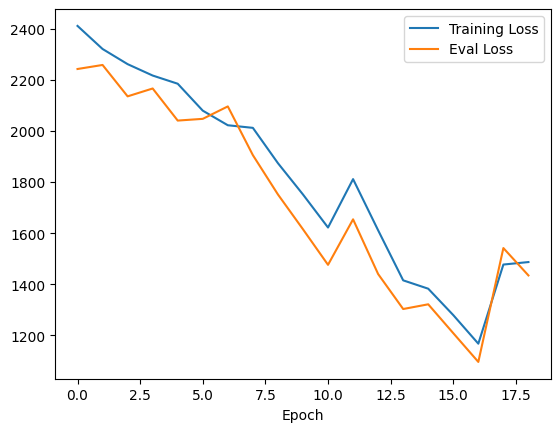

In [33]:
# training_loss_per_epoch, val_loss_per_epoch = train(
#     model,
#     train_loader,
#     test_loader,
#     optimizer,
#     criterion,
#     device,
#     num_epochs=25
#   )
